In [32]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [33]:
# Load data
freq_data = np.genfromtxt("TTF_Data_100.000_1.500_2.500.csv.csv")

# Load pickle
with open("TTF_data.pt", "rb") as f:
    TTF_data = pickle.load(f)

with open("Vs_values.pt", "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

# Get Vs_data less than 800
index = Vs_data < 200
TTF_data = TTF_data[index]
Vs_data = Vs_data[index]

print(TTF_data.shape, Vs_data.shape)


(21, 256) (21,)


(21, 256)


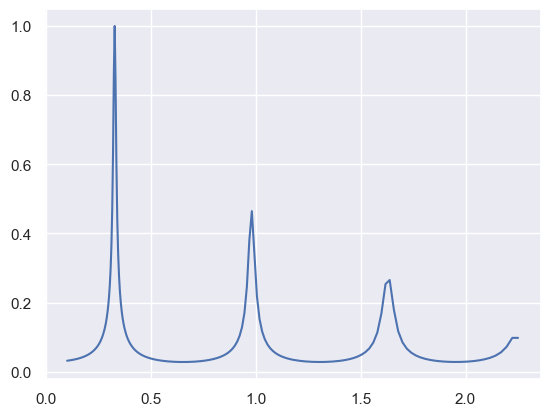

In [34]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
TTF_values = scaler.fit_transform(TTF_data.T).T
print(TTF_values.shape)

plt.plot(freq_data, TTF_values[-1,:], label="TTF")

In [35]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):

        input_data = self.Vs_values[idx] * np.ones(30)
        input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(1)

        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32).unsqueeze(1)
        return input_data, target_data

In [36]:
dataset = TTF_dataset(TTF_values, Vs_data)

# Separate into training and testing
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " ,train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Train, validation and test sizes:  16 2 3
Number of batches:  4 1 1


# Model

In [37]:
# Use Vainilla Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.input_linear = nn.Linear(input_dim, d_model)
        self.output_linear = nn.Linear(d_model, output_dim)
    
    def forward(self, src, tgt):
        src = self.input_linear(src)
        tgt = self.input_linear(tgt)
        output = self.transformer(src, tgt)
        output = self.output_linear(output[:, 0, :])  # Take the first token's output
        return output.unsqueeze(-1)

In [41]:
# Define the model
input_dim = 1
output_dim = 256

model = TransformerModel(input_dim, output_dim)

# Try it with a batch
X,y = next(iter(train_loader))



print(X.shape, y.shape)
output = model(X, y)
print(output.shape)
assert output.shape == y.shape , "Output shape is not correct"
loss_fn = nn.L1Loss()
print(loss_fn(output, y))

torch.Size([4, 30, 1]) torch.Size([4, 256, 1])
torch.Size([4, 256, 1])
tensor(0.4736, grad_fn=<MeanBackward0>)
